In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import geopy.distance as geo
from docplex.mp.model import Model

In [13]:
##### Loading school data

school_df = pd.read_csv("Schools_Coordinates.csv")
display(school_df.head())

,Unnamed: 0,School Name,Village,Coordinates,Demand
0,0,Kitchen Akshay Patra,Baroda City,"22.315718, 73.153501",x
1,1,Government School Baroda,Akota Village,"22.297335, 73.177502",234
2,2,Government School Baroda,NagarWada,"22.306992, 73.201968",249
3,3,Vasna Government School,Vasna Village,"22.298915, 73.143267",292
4,4,Government Technical School,Dandia Village,"22.300731, 73.195699",282


In [14]:
school_df = school_df.drop(columns="Unnamed: 0")
school_df['lat'] = school_df.apply(lambda school: school['Coordinates'].split(",")[0], axis = 1).astype(float)
school_df['long'] = school_df.apply(lambda school: school['Coordinates'].split(",")[1], axis = 1).astype(float)

display(school_df.head())

,School Name,Village,Coordinates,Demand,lat,long
0,Kitchen Akshay Patra,Baroda City,"22.315718, 73.153501",x,22.315718,73.153501
1,Government School Baroda,Akota Village,"22.297335, 73.177502",234,22.297335,73.177502
2,Government School Baroda,NagarWada,"22.306992, 73.201968",249,22.306992,73.201968
3,Vasna Government School,Vasna Village,"22.298915, 73.143267",292,22.298915,73.143267
4,Government Technical School,Dandia Village,"22.300731, 73.195699",282,22.300731,73.195699


In [16]:
##### Calculating distance between each vertex (schools + kicthen) 

n = len(school_df.Coordinates)
school_distance = np.zeros([n,n])

for i in range(n):
    coords_1 = school_df.Coordinates[i]
    for j in range(n):
        coords_2 = school_df.Coordinates[j]
        school_distance[i][j] = geo.distance(coords_1, coords_2).km
print(school_distance)

[[0.         3.2030747  5.08643235 ... 6.34666122 5.91750956 2.38476592]
 [3.2030747  0.         2.73844846 ... 3.50651815 4.25541329 1.29478747]
 [5.08643235 2.73844846 0.         ... 1.52518439 1.71420922 2.74077072]
 ...
 [6.34666122 3.50651815 1.52518439 ... 0.         2.62320192 3.96256955]
 [5.91750956 4.25541329 1.71420922 ... 2.62320192 0.         3.84478295]
 [2.38476592 1.29478747 2.74077072 ... 3.96256955 3.84478295 0.        ]]


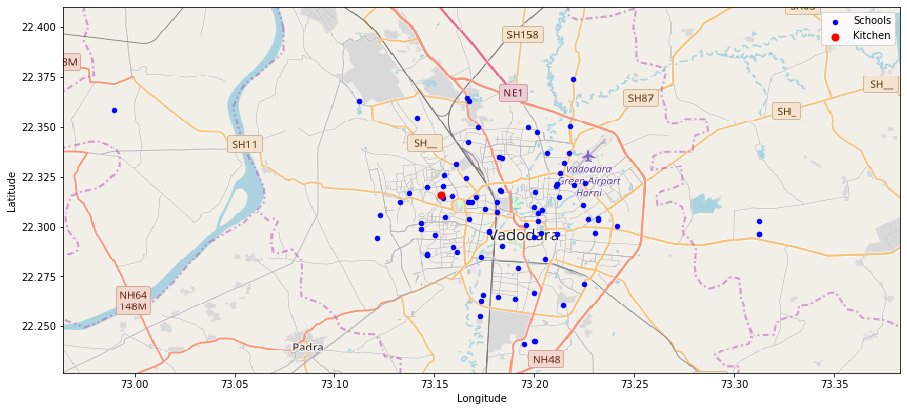

In [17]:
##### Plotting schools on map

figure, ax = plt.subplots(figsize = (15,15))
ax.scatter(school_df['long'], school_df['lat'], zorder=1, alpha= 1, c='b', s=20)
ax.scatter(school_df['long'][0], school_df['lat'][0], zorder=1, alpha= 1, c='r', marker = 'o', s=50)

BBox1 = (72.9643, 73.3832, 22.2268, 22.4098)
ruh_m1 = plt.imread('map8.png')

ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_xlim(BBox1[0],BBox1[1])
ax.set_ylim(BBox1[2],BBox1[3])
ax.imshow(ruh_m1, zorder=0, extent = BBox1, aspect = 'equal')
ax.legend(['Schools','Kitchen'])
plt.show()

In [27]:
##### Defining parameters for mathematical model

n = len(school_df) - 1                                   ## number of schools
N = [i for i in range(1, n+1)]                           ## set of schools
V = [0] + N                                              ## set of vertices
A = [(i, j) for i in V for j in V if i != j]

q = school_df['Demand'].to_numpy().astype(int)                       ## demand for schools
q[0] = 0
        
f = 3000                                                 ## fixed cost of renting truck
Q = 3600                                                 ## capacity of truck
c = 13                                                   ## cost per km of truck
d = {(i, j): school_distance[i][j] for i, j in A}        ## distance between vertices
t = {(i, j): school_distance[i][j]/50 for i, j in A}     ## time to travel between vertices

In [28]:
q

array([  0, 234, 249, 292, 282, 255, 229, 205, 230, 295, 292, 237, 242,
       223, 237, 281, 242, 275, 260, 286, 223, 278, 286, 260, 242, 220,
       225, 284, 286, 289, 258, 260, 257, 214, 206, 242, 261, 236, 212,
       254, 260, 229, 237, 299, 230, 254, 255, 268, 240, 218, 224, 246,
       293, 258, 239, 246, 235, 213, 290, 236, 224, 276, 289, 300, 268,
       255, 232, 278, 240, 200, 255, 220, 296, 290, 258, 208, 275, 295,
       259, 218, 203, 270, 201, 211, 238, 263, 244, 235, 270])

In [29]:
##### Implementation of mathematical model on CPLEX

mdl = Model('CVRP')

x = mdl.binary_var_dict(A, name='x')
u = mdl.continuous_var_dict(N, ub=Q, name='u')
w = mdl.continuous_var(lb = 0 ,name='w')

mdl.minimize(f*w + mdl.sum(c*d[i, j]*x[i, j] for i, j in A))

mdl.add_constraints(mdl.sum(x[i, j] for j in V if j != i) == 1 for i in N)
mdl.add_constraints(mdl.sum(x[i, j] for i in V if i != j) == 1 for j in N)
mdl.add_constraints(mdl.sum(x[i, j] for j in V if j != 0) == w for i in V if i ==0)
mdl.add_indicator_constraints(mdl.indicator_constraint(x[i, j], u[i] + q[j] == u[j]) for i, j in A if i != 0 and j != 0)

mdl.add_constraints(u[i] >= q[i] for i in N)
mdl.parameters.timelimit = 2000
solution = mdl.solve(log_output=False)

In [30]:
print(mdl.solution)

solution for: CVRP
objective: 23357.7
x_0_7=1
x_0_26=1
x_0_27=1
x_0_46=1
x_0_60=1
x_0_62=1
x_0_79=1
x_1_61=1
x_2_24=1
x_3_0=1
x_4_77=1
x_5_83=1
x_6_51=1
x_7_48=1
x_8_16=1
x_9_64=1
x_10_3=1
x_11_49=1
x_12_21=1
x_13_42=1
x_14_0=1
x_15_82=1
x_16_66=1
x_17_68=1
x_18_69=1
x_19_37=1
x_20_19=1
x_21_38=1
x_22_18=1
x_23_54=1
x_24_22=1
x_25_74=1
x_26_12=1
x_27_86=1
x_28_36=1
x_29_20=1
x_30_8=1
x_31_47=1
x_32_63=1
x_33_67=1
x_34_44=1
x_35_23=1
x_36_35=1
x_37_0=1
x_38_39=1
x_39_9=1
x_40_88=1
x_41_32=1
x_42_45=1
x_43_41=1
x_44_0=1
x_45_31=1
x_46_75=1
x_47_5=1
x_48_71=1
x_49_15=1
x_50_73=1
x_51_13=1
x_52_65=1
x_53_28=1
x_54_50=1
x_55_56=1
x_56_25=1
x_57_17=1
x_58_2=1
x_59_81=1
x_60_57=1
x_61_78=1
x_62_55=1
x_63_6=1
x_64_85=1
x_65_0=1
x_66_52=1
x_67_0=1
x_68_10=1
x_69_87=1
x_70_33=1
x_71_84=1
x_72_70=1
x_73_14=1
x_74_1=1
x_75_76=1
x_76_53=1
x_77_58=1
x_78_40=1
x_79_43=1
x_80_4=1
x_81_29=1
x_82_30=1
x_83_0=1
x_84_11=1
x_85_59=1
x_86_80=1
x_87_34=1
x_88_72=1
u_1=1482.000
u_2=1941.000
u_3=1536.000
u_4=1

In [31]:
active_arcs = [a for a in A if x[a].solution_value > 0.9]
print(active_arcs)

[(0, 7), (0, 26), (0, 27), (0, 46), (0, 60), (0, 62), (0, 79), (1, 61), (2, 24), (3, 0), (4, 77), (5, 83), (6, 51), (7, 48), (8, 16), (9, 64), (10, 3), (11, 49), (12, 21), (13, 42), (14, 0), (15, 82), (16, 66), (17, 68), (18, 69), (19, 37), (20, 19), (21, 38), (22, 18), (23, 54), (24, 22), (25, 74), (26, 12), (27, 86), (28, 36), (29, 20), (30, 8), (31, 47), (32, 63), (33, 67), (34, 44), (35, 23), (36, 35), (37, 0), (38, 39), (39, 9), (40, 88), (41, 32), (42, 45), (43, 41), (44, 0), (45, 31), (46, 75), (47, 5), (48, 71), (49, 15), (50, 73), (51, 13), (52, 65), (53, 28), (54, 50), (55, 56), (56, 25), (57, 17), (58, 2), (59, 81), (60, 57), (61, 78), (62, 55), (63, 6), (64, 85), (65, 0), (66, 52), (67, 0), (68, 10), (69, 87), (70, 33), (71, 84), (72, 70), (73, 14), (74, 1), (75, 76), (76, 53), (77, 58), (78, 40), (79, 43), (80, 4), (81, 29), (82, 30), (83, 0), (84, 11), (85, 59), (86, 80), (87, 34), (88, 72)]


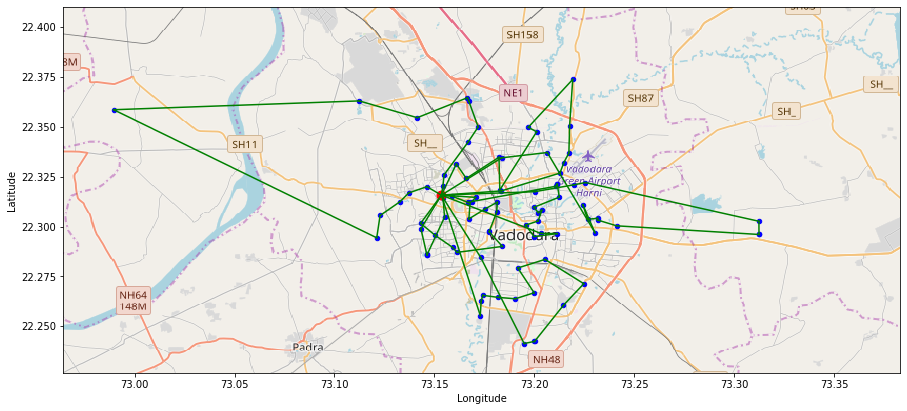

In [32]:
##### Displaying vehicle routes on map

figure, ax = plt.subplots(figsize = (15,15))

ax.scatter(school_df['long'], school_df['lat'], zorder=1, alpha= 1, c='b', s=20)
ax.scatter(school_df['long'][0], school_df['lat'][0], zorder=1, alpha= 1, c='r', marker = 'o', s=80)
BBox1 = (72.9643, 73.3832, 22.2268, 22.4098)
ruh_m1 = plt.imread('map8.png')

for i, j in active_arcs:
    ax.plot([school_df['long'][i], school_df['long'][j]], [school_df['lat'][i], school_df['lat'][j]], c='g', alpha=1)

ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_xlim(BBox1[0],BBox1[1])
ax.set_ylim(BBox1[2],BBox1[3])
ax.imshow(ruh_m1, zorder=0, extent = BBox1, aspect = 'equal')
plt.show()

In [139]:
##### Importing crossdocking data

crossdocking_df = pd.read_csv("C:/Users/rifle/Documents/My Docs/Concordia/2 - Winter 2020/INDU 6121 - Applied Optimization/Project/Data/Crossdocking _co-ordinates.csv")

crossdocking_df = crossdocking_df.drop(columns="Unnamed: 0")
crossdocking_df['lat'] = crossdocking_df.apply(lambda site: site['Coordinates'].split(",")[0], axis = 1).astype(float)
crossdocking_df['long'] = crossdocking_df.apply(lambda site: site['Coordinates'].split(",")[1], axis = 1).astype(float)

display(crossdocking_df)

,Coordinates,lat,long
0,"22.315718, 73.153501",22.315718,73.153501
1,"22.301166, 73.201483",22.301166,73.201483
2,"22.263564, 73.190167",22.263564,73.190167
3,"22.310159, 73.239059",22.310159,73.239059
4,"22.268982, 73.157204",22.268982,73.157204
5,"22.348579, 73.191896",22.348579,73.191896
6,"22.242878, 73.206868",22.242878,73.206868
7,"22.298295, 73.187849",22.298295,73.187849
8,"22.335076, 73.210569",22.335076,73.210569


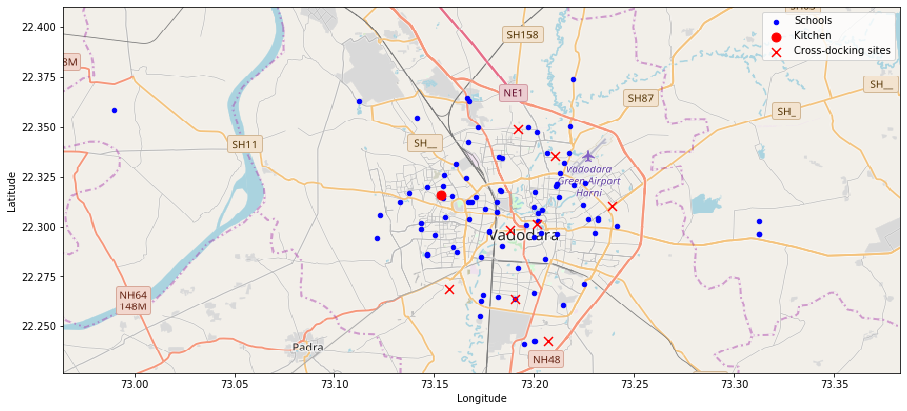

In [151]:
##### Plotting cross-docking sites on map

figure, ax = plt.subplots(figsize = (15,15))
ax.scatter(school_df['long'], school_df['lat'], zorder=1, alpha= 1, c='b', s=20)
ax.scatter(school_df['long'][0], school_df['lat'][0], zorder=1, alpha= 1, c='r', marker = 'o', s=80)
ax.scatter(crossdocking_df['long'][1:], crossdocking_df['lat'][1:], zorder=1, alpha= 1, c='r',marker = 'x', s=80)

BBox1 = (72.9643, 73.3832, 22.2268, 22.4098)
ruh_m1 = plt.imread('map8.png')

ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_xlim(BBox1[0],BBox1[1])
ax.set_ylim(BBox1[2],BBox1[3])
ax.imshow(ruh_m1, zorder=0, extent = BBox1, aspect = 'equal')
ax.legend(['Schools','Kitchen','Cross-docking sites'])
plt.show()

In [141]:
##### Calculating distance between cross-docking sites and schools

CD_distance = np.zeros([len(crossdocking_df),len(school_df)-1])
for i in range(len(crossdocking_df)):
    coords_1 = crossdocking_df.Coordinates[i]
    for j in range(1,len(school_df)):
        coords_2 = school_df.Coordinates[j]
        CD_distance[i][j-1] = geo.distance(coords_1, coords_2).km
        
print(CD_distance)

[[ 3.2030747   5.08643235  2.1387031   4.65393397  1.68717819  5.56546383
   6.96622804  8.76897029  8.15676196  3.32424414  6.89632804  5.95088533
   6.72240057  1.89509649  5.64222619  9.4268607   3.38413313  6.0062509
   6.84518954  7.45772228  8.18977625  6.08209679  6.03849959  4.81973685
   3.27358358  3.73486136  5.54597705  7.6386356  16.43933592  8.83599675
   3.35532079  4.22832011  1.44379486  1.61904008  5.84918837  9.32879326
   4.82031055  7.31193805  7.65850398  2.91480523  3.27292527 17.54738351
   1.13405982  1.77284086  4.0860556   3.09705122  2.16903296  6.23410104
   7.22208123  3.63794474  4.46943221  9.26735167  6.97873706  3.0278719
   2.2530072   2.95032467  1.23513808  5.25080625 16.52231828  0.19219752
   3.18694843  1.89705456  5.40350629  8.17081514  3.99805099  9.41749312
   0.52634385  3.39623889  5.99213515  1.53754904  5.94932194  1.93537265
   1.58253491  4.24078369  6.23642744  6.56489402  5.19029621  3.00448518
   0.48887075  5.29984903 16.52189201  6